# Oxford Pets - Multiclass Classification

## Modules

In [1]:
import os
import sys

common_dir = os.path.abspath("../../common")
print(os.listdir(common_dir))

if common_dir not in sys.path:
    sys.path.append(common_dir)

['pt_trainer.py', 'tf_trainer.py', 'utils.py', '__pycache__']


In [2]:
import tensorflow as tf
from tensorflow import keras

import random
import numpy as np
import matplotlib.pyplot as plt

from utils import show_images, plot_progress
from tf_trainer import TrainerWithMetrics, TrainerWithEarlyStopping
from tf_trainer import accuracy, binary_accuracy
from scipy.special import softmax, expit as sigmoid

os.environ["TF_CPP_MIN_LOG_LEVEL"] = '3'

## Parameters

In [3]:
seed = 42
random.seed(seed)
np.random.seed(seed)
tf.random.set_seed(seed)

In [4]:
image_size = (224, 224)
batch_size = 32

In [5]:
save_weights = False
weights_name = "./tf_models/tf_oxford-pets_clf-37.h5"

## Data Set

In [6]:
from glob import glob
import re
from sklearn.preprocessing import LabelEncoder
from collections import Counter

def get_paths(image_dir, formats=["*"]):
    invalid_images = ['Egyptian_Mau_14',  'Egyptian_Mau_139', 'Egyptian_Mau_145',
                      'Egyptian_Mau_156', 'Egyptian_Mau_167', 'Egyptian_Mau_177',
                      'Egyptian_Mau_186', 'Egyptian_Mau_191', 'Abyssinian_5',
                      'Abyssinian_34',    'chihuahua_121',    'beagle_116']
    paths = []
    for ext in formats:
        paths += glob(os.path.join(image_dir, f"*.{ext}"))

    valid_paths = []
    for path in paths:
        image_name = os.path.basename(path).split('.')[0]
        if image_name not in invalid_images:
            valid_paths.append(path)
    return valid_paths

def get_labels(image_paths, n_classes=37):
    image_names = [os.path.basename(path).split('.')[0] for path in image_paths]
    if n_classes == 2:
        labels = ['cat' if name[0].isupper() else 'dog' for name in image_names]
    else:
        labels = [re.sub('_\d+', '', name) for name in image_names]
    return labels

def get_class_names(labels):
    return list(Counter(labels).keys())

def label_encoder(labels, class_names):
    encoder = {name: i for i, name in enumerate(class_names)}
    return [encoder[label] for label in labels]

In [7]:
import xml.etree.ElementTree as et

def change_paths(new_dir, old_paths, replace=("ext1", "ext2")):
    filenames = [os.path.basename(path).replace(replace[0], replace[1])
                 for path in old_paths]
    return [os.path.join(new_dir, name) for name in filenames]

def get_bboxes(bbox_paths):
    bboxes = []
    for path in bbox_paths:
        tree = et.parse(path)

        width = float(tree.find('./size/width').text)
        height = float(tree.find('./size/height').text)
        xmin = float(tree.find('./object/bndbox/xmin').text)
        xmax = float(tree.find('./object/bndbox/xmax').text)
        ymin = float(tree.find('./object/bndbox/ymin').text)
        ymax = float(tree.find('./object/bndbox/ymax').text)

        x = (xmax + xmin)/width/2
        y = (ymax + ymin)/height/2
        w = (xmax - xmin)/width
        h = (ymax - ymin)/height
        bboxes.append([x, y, w, h])
    return bboxes

In [8]:
data_dir = "/mnt/f/deep_learning/datasets/oxford_pets_783M/"
image_dir = os.path.join(data_dir, "images")
bbox_dir = os.path.join(data_dir, "annotations", "xmls")

bbox_paths = get_paths(bbox_dir, formats=['xml'])
image_paths = change_paths(image_dir, bbox_paths, replace=['xml', 'jpg'])
labels = get_labels(bbox_paths, n_classes=37)
class_names = get_class_names(labels)
labels = label_encoder(labels, class_names)

print(f">> Images: {len(bbox_paths)}")
print(">> Class Names:", class_names)

>> Images: 3684
>> Class Names: ['Abyssinian', 'american_bulldog', 'american_pit_bull_terrier', 'basset_hound', 'beagle', 'Bengal', 'Birman', 'Bombay', 'boxer', 'British_Shorthair', 'chihuahua', 'Egyptian_Mau', 'english_cocker_spaniel', 'english_setter', 'german_shorthaired', 'great_pyrenees', 'havanese', 'japanese_chin', 'keeshond', 'leonberger', 'Maine_Coon', 'miniature_pinscher', 'newfoundland', 'Persian', 'pomeranian', 'pug', 'Ragdoll', 'Russian_Blue', 'saint_bernard', 'samoyed', 'scottish_terrier', 'shiba_inu', 'Siamese', 'Sphynx', 'staffordshire_bull_terrier', 'wheaten_terrier', 'yorkshire_terrier']


In [9]:
from sklearn.model_selection import train_test_split

train_image_paths, test_image_paths, train_labels, test_labels = train_test_split(
    image_paths, labels, stratify=labels, train_size=0.8, random_state=seed)

train_image_paths, valid_image_paths, train_labels, valid_labels = train_test_split(
    train_image_paths, train_labels, stratify=train_labels, train_size=0.75, random_state=seed)

train_bbox_paths = change_paths(bbox_dir, train_image_paths, replace=['jpg', 'xml'])
valid_bbox_paths = change_paths(bbox_dir, valid_image_paths, replace=['jpg', 'xml'])
test_bbox_paths = change_paths(bbox_dir, test_image_paths, replace=['jpg', 'xml'])

train_bboxes = get_bboxes(train_bbox_paths)
valid_bboxes = get_bboxes(valid_bbox_paths)
test_bboxes = get_bboxes(test_bbox_paths)

n_images = len(image_paths)
print(f">> Train images: {len(train_image_paths)} ({len(train_image_paths)/n_images:.2f})")
print(f">> Valid images: {len(valid_image_paths)} ({len(valid_image_paths)/n_images:.2f})")
print(f">> Test  images: {len(test_image_paths)} ({len(test_image_paths)/n_images:.2f})")

>> Train images: 2210 (0.60)
>> Valid images: 737 (0.20)
>> Test  images: 737 (0.20)


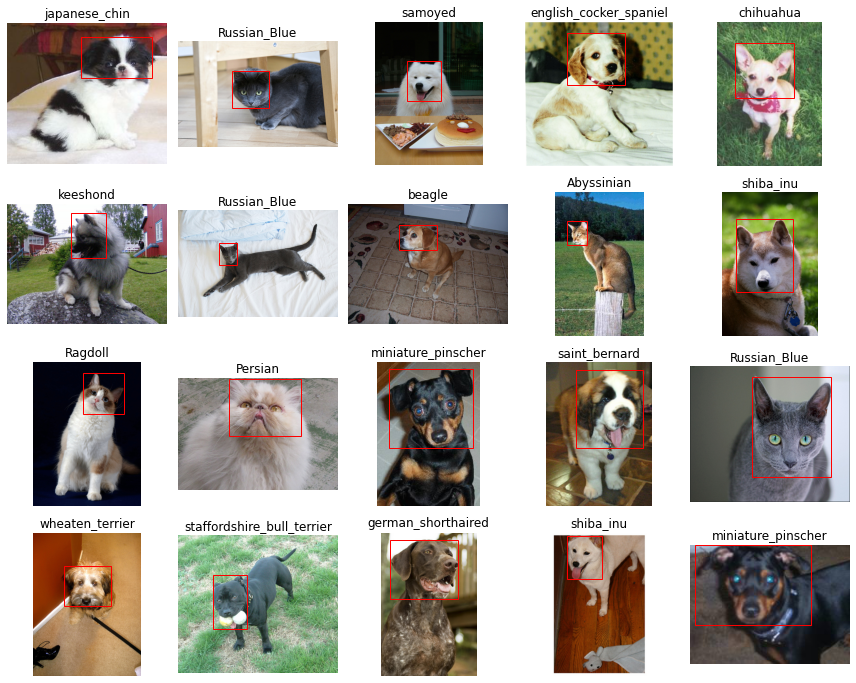

In [10]:
n_samples = 20
show_images(train_image_paths[:n_samples], labels=train_labels[:n_samples],
            bboxes=train_bboxes[:n_samples], class_names=class_names)

## Data Loader

In [11]:
import albumentations as A
from functools import partial

@tf.function
def load_data(image_path, bbox, label):
    image = tf.io.read_file(image_path)
    image = tf.io.decode_jpeg(image, channels=3)
    return image, bbox, label

def augmenation(image, bbox, label, training):
    transform = train_transform if training else valid_transform
    transformed = transform(image=image, bboxes=[bbox], labels=[label])
    image = transformed['image']
    bbox = transformed['bboxes'][0]     # tuple
    label = transformed['labels'][0]    # not tuple
    bbox_label = bbox + (label,)

    # image = tf.cast(image, dtype=tf.float32)/255
    image = tf.cast(image, dtype=tf.float32)
    bbox_label = tf.cast(bbox_label, dtype=tf.float32)
    return image, bbox_label

@tf.function
def preprocess(image, bbox, label, training):
    image, bbox_label = tf.numpy_function(augmenation,
                        inp=[image, bbox, label, training],
                        Tout=[tf.float32, tf.float32])
    return image, bbox_label

def get_dataloader(image_paths, bboxes, labels, batch_size, training, shuffle=True):
    AUTOTUNE = tf.data.experimental.AUTOTUNE
    dataloader = tf.data.Dataset.from_tensor_slices((image_paths, bboxes, labels)).cache()
    dataloader = dataloader.map(load_data, num_parallel_calls=AUTOTUNE)
    dataloader = dataloader.map(partial(preprocess, training=training),
                                num_parallel_calls=AUTOTUNE)
    if shuffle:
        dataloader = dataloader.shuffle(1000)
    dataloader = dataloader.batch(batch_size).prefetch(AUTOTUNE)
    return dataloader

train_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    A.HorizontalFlip(p=0.5),
    A.VerticalFlip(p=0.5),
    A.ShiftScaleRotate(p=0.5, shift_limit=0.05, scale_limit=0.05, 
                       rotate_limit=15,),
    # A.CoarseDropout(p=0.5, max_holes=8, max_height=int(0.1*image_size[0]), 
    #                 max_width=int(0.1*image_size[1])),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

valid_transform = A.Compose([
    A.Resize(height=image_size[0], width=image_size[1]),
    # A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
    ], bbox_params=A.BboxParams(format='yolo', label_fields=['labels']))

train_loader = get_dataloader(train_image_paths, train_bboxes, train_labels, 
                              batch_size, training=True, shuffle=True)
valid_loader = get_dataloader(valid_image_paths, valid_bboxes, valid_labels, 
                              batch_size, training=False, shuffle=False)
test_loader = get_dataloader(test_image_paths, test_bboxes, test_labels, 
                             batch_size, training=False, shuffle=False)

<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 224, 224, 3) <dtype: 'float32'>
<class 'tensorflow.python.framework.ops.EagerTensor'> (32, 5) <dtype: 'float32'>
>> Images: min: 0, max: 255
>> BBoxes: min: 0.16393040120601654, max: 0.9929103255271912
>> Labels: min: 1.0, max: 35.0


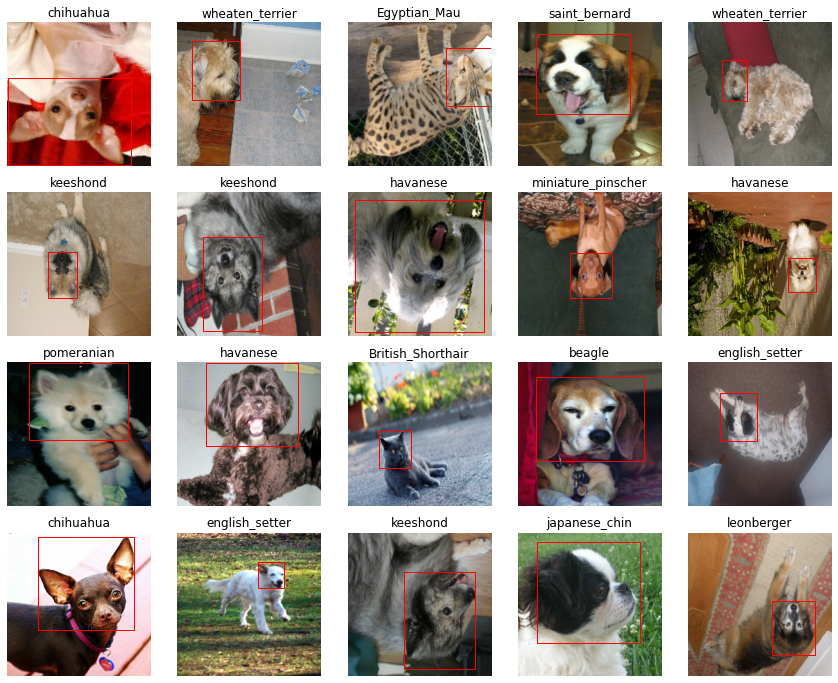

In [12]:
images, bboxes_labels = next(iter(train_loader))
print(type(images), images.shape, images.dtype)
print(type(bboxes_labels), bboxes_labels.shape, bboxes_labels.dtype)

images = images.numpy().astype(int)
bboxes_labels = bboxes_labels.numpy()
bboxes, labels = bboxes_labels[:, :4], bboxes_labels[:, 4:]

n_samples = 20
print(f">> Images: min: {images.min()}, max: {images.max()}")
print(f">> BBoxes: min: {bboxes.min()}, max: {bboxes.max()}")
print(f">> Labels: min: {labels.min()}, max: {labels.max()}")
show_images(images[:n_samples], labels=labels[:n_samples], 
            class_names=class_names, bboxes=bboxes[:n_samples])

### Modeling

In [13]:
from  tensorflow.keras.applications import mobilenet_v2
from  tensorflow.keras.applications import efficientnet_v2

pretrained_models = {'mobilenetv2': mobilenet_v2.MobileNetV2,
                     'efficientnetv2': efficientnet_v2.EfficientNetV2S}
preprocess_inputs = {'mobilenetv2': mobilenet_v2.preprocess_input,
                     'efficientnetv2': efficientnet_v2.preprocess_input}

def get_pretrained_model(model_name, input_shape, n_classes, freezed=True):
    base_model = pretrained_models[model_name](input_shape=input_shape,
                             weights='imagenet', include_top=False)
    base_model.trainable = not freezed

    inputs = keras.Input(input_shape)
    x = preprocess_inputs[model_name](inputs)
    x = base_model(x)

    x = keras.layers.GlobalAveragePooling2D()(x)
    x = keras.layers.Dense(256)(x)
    x = keras.layers.ReLU()(x)
    x = keras.layers.BatchNormalization()(x)
    outputs = keras.layers.Dense(n_classes)(x)
    return keras.Model(inputs, outputs)

In [18]:
@tf.function
def mse_loss(y_true, y_pred):
    y_true, y_pred = y_true[:, :4], y_pred[:, :4]
    # y_pred = tf.sigmoid(y_pred)
    loss_fn = keras.losses.MeanSquaredError()
    return loss_fn(y_true, y_pred)

@tf.function
def ce_loss(y_true, y_pred):
    y_true, y_pred = tf.squeeze(y_true[:, 4:]), y_pred[:, 4:]
    loss_fn = keras.losses.SparseCategoricalCrossentropy(from_logits=True)
    return loss_fn(y_true, y_pred)

@tf.function
def acc(y_true, y_pred):
    y_true, y_pred = tf.squeeze(y_true[:, 4:]), y_pred[:, 4:]
    y_pred = tf.argmax(y_pred, axis=-1)                 ## int64
    y_true = tf.cast(y_true, tf.int64)
    return tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), tf.float32))

@tf.function
def total_loss(y_true, y_pred):
    return mse_loss(y_true, y_pred) + ce_loss(y_true, y_pred)

@tf.function
def iou(box1, box2):
    x1, y1, w1, h1 = box1[:, 0], box1[:, 1], box1[:, 2], box1[:, 3]
    x2, y2, w2, h2 = box2[:, 0], box2[:, 1], box2[:, 2], box2[:, 3]

    inter_w = tf.minimum(x1 + w1/2, x2 + w2/2) - tf.maximum(x1 - w1/2, x2 - w2/2)
    inter_h = tf.minimum(y1 + h1/2, y2 + h2/2) - tf.maximum(y1 - h1/2, y2 - h2/2)
    intersection = tf.maximum(inter_w, 0.)*tf.maximum(inter_h, 0.)
    union = w1*h1 + w2*h2 - intersection
    return tf.reduce_mean(intersection / union)

## Training

In [19]:
%%time
## Feature Extraction

model = get_pretrained_model('efficientnetv2', input_shape=(224, 224, 3), n_classes=4+37, freezed=True)
optimizer = keras.optimizers.Adam()
loss_fn = total_loss
metrics = {'mse': mse_loss, 'ce': ce_loss, 'iou': iou, 'acc': acc}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=10, valid_loader=valid_loader)

# results = clf.evaluate(test_loader)
# print(">>", ', '.join([f"test_{key}={value:.4f}" 
#                        for key, value in results.items()]))

Epoch[  1/ 10] loss=1.9479, mse=0.6626, ce=1.2853, iou=0.0178, acc=0.6455 | val_loss=1.0263, val_mse=0.0600, val_ce=0.9662, val_iou=0.1289, val_acc=0.8932 (1)
Epoch[  2/ 10] loss=0.7290, mse=0.2133, ce=0.5157, iou=0.0568, acc=0.8487 | val_loss=0.5371, val_mse=0.0647, val_ce=0.4724, val_iou=0.1497, val_acc=0.9206 (1)
Epoch[  3/ 10] loss=0.5656, mse=0.1487, ce=0.4169, iou=0.0838, acc=0.8728 | val_loss=0.3812, val_mse=0.0652, val_ce=0.3160, val_iou=0.1472, val_acc=0.9271 (1)
Epoch[  4/ 10] loss=0.4623, mse=0.1101, ce=0.3522, iou=0.1143, acc=0.8938 | val_loss=0.3259, val_mse=0.0607, val_ce=0.2651, val_iou=0.1831, val_acc=0.8919 (1)
Epoch[  5/ 10] loss=0.3871, mse=0.1020, ce=0.2851, iou=0.1264, acc=0.9134 | val_loss=0.2991, val_mse=0.0567, val_ce=0.2424, val_iou=0.1757, val_acc=0.9349 (1)
Epoch[  6/ 10] loss=0.3456, mse=0.0794, ce=0.2662, iou=0.1506, acc=0.9223 | val_loss=0.2964, val_mse=0.0503, val_ce=0.2461, val_iou=0.1975, val_acc=0.8932 (1)
Epoch[  7/ 10] loss=0.3122, mse=0.0684, ce=0.2

In [20]:
%%time
## Feature Extraction

model = get_pretrained_model('efficientnetv2', input_shape=(224, 224, 3), n_classes=4+37, freezed=True)
optimizer = keras.optimizers.Adam()
loss_fn = mse_loss
metrics = {'mse': mse_loss, 'ce': ce_loss, 'iou': iou, 'acc': acc}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=10, valid_loader=valid_loader)

# results = clf.evaluate(test_loader)
# print(">>", ', '.join([f"test_{key}={value:.4f}" 
#                        for key, value in results.items()]))

Epoch[  1/ 10] loss=0.7735, mse=0.7735, ce=4.3783, iou=0.0155, acc=0.0237 | val_loss=0.0679, val_mse=0.0679, val_ce=3.7317, val_iou=0.2048, val_acc=0.0339 (1)
Epoch[  2/ 10] loss=0.2198, mse=0.2198, ce=4.2726, iou=0.0602, acc=0.0250 | val_loss=0.0678, val_mse=0.0678, val_ce=3.8359, val_iou=0.1523, val_acc=0.0326 (1)
Epoch[  3/ 10] loss=0.1316, mse=0.1316, ce=4.3500, iou=0.0962, acc=0.0259 | val_loss=0.0648, val_mse=0.0648, val_ce=4.0189, val_iou=0.1797, val_acc=0.0273 (1)
Epoch[  4/ 10] loss=0.0931, mse=0.0931, ce=4.3253, iou=0.1326, acc=0.0326 | val_loss=0.0589, val_mse=0.0589, val_ce=4.1977, val_iou=0.2112, val_acc=0.0221 (1)
Epoch[  5/ 10] loss=0.0697, mse=0.0697, ce=4.3551, iou=0.1591, acc=0.0192 | val_loss=0.0466, val_mse=0.0466, val_ce=4.3016, val_iou=0.2287, val_acc=0.0234 (1)
Epoch[  6/ 10] loss=0.0554, mse=0.0554, ce=4.3192, iou=0.1881, acc=0.0295 | val_loss=0.0410, val_mse=0.0410, val_ce=4.3555, val_iou=0.2365, val_acc=0.0234 (1)
Epoch[  7/ 10] loss=0.0500, mse=0.0500, ce=4.3

In [21]:
%%time
## Feature Extraction

# model = get_pretrained_model('efficientnetv2', input_shape=(224, 224, 3), n_classes=4+37, freezed=True)
optimizer = keras.optimizers.Adam()
loss_fn = total_loss
metrics = {'mse': mse_loss, 'ce': ce_loss, 'iou': iou, 'acc': acc}

clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
hist = clf.fit(train_loader, n_epochs=10, valid_loader=valid_loader)

# results = clf.evaluate(test_loader)
# print(">>", ', '.join([f"test_{key}={value:.4f}" 
#                        for key, value in results.items()]))

Epoch[  1/ 10] loss=1.3575, mse=0.0493, ce=1.3082, iou=0.2092, acc=0.6496 | val_loss=0.4358, val_mse=0.0437, val_ce=0.3921, val_iou=0.1874, val_acc=0.8581 (1)
Epoch[  2/ 10] loss=0.5585, mse=0.0462, ce=0.5123, iou=0.2147, acc=0.8433 | val_loss=0.3087, val_mse=0.0378, val_ce=0.2710, val_iou=0.2146, val_acc=0.9219 (1)
Epoch[  3/ 10] loss=0.4291, mse=0.0423, ce=0.3868, iou=0.2392, acc=0.8821 | val_loss=0.4141, val_mse=0.0417, val_ce=0.3724, val_iou=0.2522, val_acc=0.8880 (2)
Epoch[  4/ 10] loss=0.3939, mse=0.0403, ce=0.3536, iou=0.2453, acc=0.8866 | val_loss=0.2914, val_mse=0.0329, val_ce=0.2585, val_iou=0.2709, val_acc=0.8906 (1)
Epoch[  5/ 10] loss=0.3181, mse=0.0374, ce=0.2807, iou=0.2545, acc=0.9179 | val_loss=0.2863, val_mse=0.0303, val_ce=0.2560, val_iou=0.2850, val_acc=0.8880 (1)
Epoch[  6/ 10] loss=0.2740, mse=0.0353, ce=0.2388, iou=0.2652, acc=0.9295 | val_loss=0.2639, val_mse=0.0275, val_ce=0.2364, val_iou=0.3052, val_acc=0.9232 (1)
Epoch[  7/ 10] loss=0.2084, mse=0.0315, ce=0.1

In [ ]:
# %%time
# ## Fine Tuneing

# model.trainable = True

# optimizer = keras.optimizers.Adam(learning_rate=1e-5)
# clf = TrainerWithEarlyStopping(model, optimizer, loss_fn, metrics)
# hist = clf.fit(train_loader, n_epochs=100, valid_loader=valid_loader)

# results = clf.evaluate(test_loader)
# print(">>", ', '.join([f"test_{key}={value:.4f}" 
#                        for key, value in results.items()]))

In [ ]:
# clf = TrainerWithMetrics(model, optimizer, loss_fn, metrics={'acc': accuracy})
# hist = clf.fit(valid_loader, n_epochs=3)

# results = clf.evaluate(test_loader)
# print(">>", ', '.join([f"test_{key}={value:.4f}" 
#                        for key, value in results.items()]))

In [ ]:
# if save_weights:
#     model.save_weights(weights_name)

## Inference

In [ ]:
# if save_weights:
#     model = get_pretrained_model('efficientnetv2', input_shape=(224, 224, 3), n_classes=4+37, freezed=True)
#     model.load_weights(weights_name)

In [ ]:
# images, bboxes_labels = next(iter(test_loader))
# preds = model.predict(images)

# images = images.numpy().astype(int)
# bboxes_labels = bboxes_labels.numpy()
# bboxes, labels = bboxes_labels[:, :4], bboxes_labels[:, 4:]
# pred_bboxes, pred_labels = preds[:, :4], preds[:, 4:].argmax(axis=-1)

# n_samples = 12
# print(f">> Ground Truth:")
# show_images(images[:n_samples], labels=labels[:n_samples], class_names=class_names,
#             bboxes=bboxes[:n_samples], n_cols=6)

# print(f">> Predictions:")
# show_images(images[:n_samples], labels=pred_labels[:n_samples], class_names=class_names,
#             bboxes=bboxes[:n_samples], 
#             bboxes2=pred_bboxes[:n_samples], bbox_color2='b', n_cols=6)